# This is a Jupyter notebook for David Dobrinskiy's HSE Thesis
## How Venture Capital Affects Startups' Success


In [1]:
# You should be running python3

import sys
print(sys.version)

3.4.5 |Anaconda 2.3.0 (64-bit)| (default, Jul  2 2016, 17:47:47) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
import pandas as pd  # http://pandas.pydata.org/
import numpy as np   # http://numpy.org/

import statsmodels.api as sm  # http://statsmodels.sourceforge.net/stable/index.html
import statsmodels.formula.api as smf
import statsmodels

print("Pandas Version: {}".format(pd.__version__))          # pandas version
print("StatsModels Version: {}".format(statsmodels.__version__))  # StatsModels version

Pandas Version: 0.19.1
StatsModels Version: 0.6.1


### Let us look at the dynamics of total US VC investment

In [3]:
# load the pwc dataset from azure

from azureml import Workspace

ws = Workspace()
ds = ws.datasets['pwc_moneytree.csv']
frame = ds.to_dataframe()

In [4]:
frame.head()

,Quarter,Unnamed: 1,1,2,3,4,Grand Total
0,1995.0,# of Deals,503,466,434,494,"1,897"
1,NaN,Amount Invested,"$1,690,040,500","$2,546,374,500","$1,709,754,500","$2,070,353,900","$8,016,523,400"
2,1996.0,# of Deals,585,671,604,775,"2,635"
3,NaN,Amount Invested,"$2,437,964,900","$3,017,298,000","$2,606,841,300","$3,223,318,800","$11,285,423,000"
4,1997.0,# of Deals,773,778,762,919,"3,232"


In [5]:
del frame['Grand Total']
frame.columns = ['year', 'type', 'q1', 'q2', 'q3', 'q4']
frame['year'] = frame['year'].fillna(method='ffill')
frame.head()

,year,type,q1,q2,q3,q4
0,1995.0,# of Deals,503,466,434,494
1,1995.0,Amount Invested,"$1,690,040,500","$2,546,374,500","$1,709,754,500","$2,070,353,900"
2,1996.0,# of Deals,585,671,604,775
3,1996.0,Amount Invested,"$2,437,964,900","$3,017,298,000","$2,606,841,300","$3,223,318,800"
4,1997.0,# of Deals,773,778,762,919


Deals and investments are in alternating rows of **frame**, let's separate them

In [6]:
      deals_df = frame.iloc[0::2]
investments_df = frame.iloc[1::2]

In [7]:
# once separated, 'type' field is identical within each df
# let's delete it

del       deals_df['type']
del investments_df['type']

In [8]:
deals_df.head()

,year,q1,q2,q3,q4
0,1995.0,503,466,434,494
2,1996.0,585,671,604,775
4,1997.0,773,778,762,919
6,1998.0,871,912,931,"1,030"
8,1999.0,936,"1,330","1,448","1,892"


In [9]:
investments_df.head()

,year,q1,q2,q3,q4
1,1995.0,"$1,690,040,500","$2,546,374,500","$1,709,754,500","$2,070,353,900"
3,1996.0,"$2,437,964,900","$3,017,298,000","$2,606,841,300","$3,223,318,800"
5,1997.0,"$3,104,430,200","$3,691,566,400","$3,775,959,100","$4,499,598,900"
7,1998.0,"$4,199,545,200","$5,784,400,500","$5,412,295,700","$6,165,090,000"
9,1999.0,"$6,648,622,700","$11,315,434,200","$13,654,453,100","$23,340,087,500"


In [10]:
def unstack_to_series(df):
    """
    Takes q1-q4 in a dataframe and converts it to a series
    
    input: a dataframe containing ['q1', 'q2', 'q3', 'q4']
    
    ouput: a pandas series
    """
    quarters = ['q1', 'q2', 'q3', 'q4']
    d = dict()
    for i, row in df.iterrows():
        for q in quarters:
            key = str(int(row['year'])) + q
            d[key] = row[q]

            # print(key, q, row[q])
    return pd.Series(d)

In [11]:
      deals = unstack_to_series(deals_df      ).dropna()
investments = unstack_to_series(investments_df).dropna()

In [12]:
def string_to_int(money_string):
    numerals = [c if c.isnumeric() else '' for c in money_string]
    return int(''.join(numerals))

In [13]:
# convert deals from string to integers
deals = deals.apply(string_to_int)
deals.tail()

2015q3    1189
2015q4    1047
2016q1    1021
2016q2     999
2016q3     891
dtype: int64

In [14]:
# investment in billions USD
# converts to integers - which is ok, since data is in dollars
investments_b = investments.apply(string_to_int) 
# in python3 division automatically converts numbers to floats, we don't loose precicion
investments_b = investments_b / 10**9
# round data to 2 decimals
investments_b = investments_b.apply(round, ndigits=2)
investments_b.tail()

2015q3    16.71
2015q4    12.34
2016q1    12.64
2016q2    15.57
2016q3    10.63
dtype: float64

### Plot data from MoneyTree report

http://www.pwcmoneytree.com

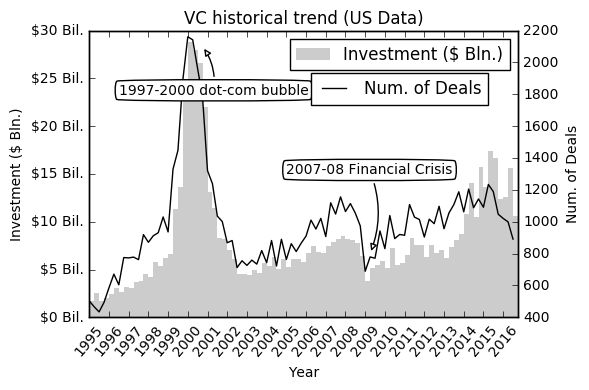

In [15]:
import matplotlib.pyplot  as plt  # http://matplotlib.org/
import matplotlib.patches as mpatches
import matplotlib.ticker  as ticker
%matplotlib inline

# change matplotlib inline display size
# import matplotlib.pylab as pylab
# pylab.rcParams['figure.figsize'] = (8, 6)  # that's default image size for this interactive session

fig, ax1 = plt.subplots()
ax1.set_title("VC historical trend (US Data)")
t = range(len(investments_b))      # need to substitute tickers for years later
width = t[1]-t[0]
y1 = investments_b

# create filled step chart for investment amount
ax1.bar(t, y1, width=width, facecolor='0.80', edgecolor='', label = 'Investment ($ Bln.)')
ax1.set_ylabel('Investment ($ Bln.)')

# set up xlabels with years
years = [str(year)[:-2] for year in deals.index][::4]  # get years without quarter 
ax1.set_xticks(t[::4])                   # set 1 tick per year
ax1.set_xticklabels(years, rotation=50)  # set tick names
ax1.set_xlabel('Year')                   # name X axis

# format Y1 tickers to $ billions
formatter = ticker.FormatStrFormatter('$%1.0f Bil.')
ax1.yaxis.set_major_formatter(formatter)
for tick in ax1.yaxis.get_major_ticks():
    tick.label1On = False
    tick.label2On = True

# create second Y2 axis for Num of Deals
ax2 = ax1.twinx()
y2 = deals
ax2.plot(t, y2, color = 'k', ls = '-', label = 'Num. of Deals')
ax2.set_ylabel('Num. of Deals')

# add annotation bubbles
ax2.annotate('1997-2000 dot-com bubble', xy=(23, 2100), xytext=(6, 1800),
                bbox=dict(boxstyle="round4", fc="w"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=0.2",
                                fc="w"),
            )

ax2.annotate('2007-08 Financial Crisis', xy=(57, 800), xytext=(40, 1300),
                bbox=dict(boxstyle="round4", fc="w"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=-0.2",
                                fc="w"), 
            )


# add legend
ax1.legend(loc="best")
ax2.legend(bbox_to_anchor=(0.95, 0.88))

fig.tight_layout()  # solves cropping problems when saving png
fig.savefig('vc_trend_3.png', dpi=250)


plt.show()

In [18]:
def tex(df):
    """
    Print dataframe contents in latex-ready format
    """
    for line in df.to_latex().split('\n'):
        print(line)

In [34]:
ds = ws.datasets['ipo_mna.csv']
frame = ds.to_dataframe()
frame.tail()

,q,IPO,MnAs
10,3Q'15,12.0,135.0
11,4Q'15,15.0,120.0
12,1Q'16,6.0,112.0
13,NaN,NaN,NaN
14,MnAs & IPOs of VC Backed companies (2013-2016),NaN,NaN


In [35]:
frame = frame.iloc[:-2]
frame = frame.set_index('q')
frame

,IPO,MnAs
q,,
1Q'13,9.0,107.0
2Q'13,20.0,98.0
3Q'13,24.0,129.0
4Q'13,20.0,139.0
1Q'14,39.0,130.0
2Q'14,24.0,128.0
3Q'14,22.0,140.0
4Q'14,23.0,116.0
1Q'15,12.0,122.0


# WSJ Unicorns

In [36]:
ds = ws.datasets['wsj_unicorns.csv']
frame = ds.to_dataframe()
frame.tail()

,Company,Latest Valuation,Total Equity Funding,Last Valuation
150,SMS Assist,$1.0 billion,$0.26 billion,June 2016
151,Liepin.com,$1.0 billion,$0.19 billion,June 2016
152,Mofang Apartments,$1.0 billion,$0.50 billion,April 2016
153,Africa Internet Group,$1.0 billion,$0.47 billion,March 2016
154,Compass,$1.0 billion,$0.21 billion,August 2016


# Most funded IPO-reaching US startups

In [37]:
# data from Founder Collective
# http://www.foundercollective.com/
ds = ws.datasets['most_funded_ipo.csv']
frame = ds.to_dataframe()
most_funded = frame.copy()
most_funded.tail()

,Firm,Founded,R1,Year,R2,Year.1,R3,Year.2,R4,Year.3,...,IPO Share Price,Current Share Price,Current Market Cap,IPO Year,IPO Raise,Acquirer,Acquired Year,Acquired Price,Sector,Geo
66,ZenDesk,2007,0.5,2008,1.55,2009,6.00,2009,19.0,2010,...,9.0,22.27,"$2,015,495,794",2014,"$100,000,000",-,-,-,B2B,SF
67,Zillow,2005,32.0,2005,25.00,2006,30.00,2007,5.5,2011,...,20.0,36.29,"$4,389,558,700",2011,"$69,200,000",-,-,-,B2C,Seattle
68,Zipcar,2000,4.7,2002,10.00,2005,25.00,2006,21.0,2010,...,18.0,12.25,"$500,000,000",2011,"$174,000,000",Avis,2013,0.5,B2C,Boston
69,Zulilly,2009,4.6,2009,6.00,2010,43.00,2011,85.0,2012,...,22.0,18.75,"$2,400,000,000",2013,"$253,000,000",Liberty Interactive,2016,2.4,B2C,Seattle
70,Zynga,2007,0.0,2007,10.00,2008,5.03,2008,25.0,2008,...,10.0,2.80,"$2,453,627,187",2011,"$1,000,000,000",-,-,-,B2C,SF


In [38]:
from datetime import datetime

most_funded['Firm age']     = datetime.now().year     - most_funded['Founded']
most_funded['Years to IPO'] = most_funded['IPO Year'] - most_funded['Founded']

In [39]:
# extract all funding rounds
# R1, R2, ... are funding rounds (Raising VC)
most_funded.iloc[:,2:22:2].tail()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,Other Funding
66,0.5,1.55,6.00,19.0,60.00,0.0,0.0,0.00,0.0,0.00
67,32.0,25.00,30.00,5.5,0.00,0.0,0.0,0.00,0.0,4.13
68,4.7,10.00,25.00,21.0,0.00,0.0,0.0,0.00,0.0,0.00
69,4.6,6.00,43.00,85.0,0.00,0.0,0.0,0.00,0.0,0.00
70,0.0,10.00,5.03,25.0,15.19,15.0,300.0,6.34,490.0,0.00


In [40]:
# [axis = 1] to sum by row instead of by-column
most_funded['VC'] = most_funded.iloc[:,2:22:2].sum(axis=1)
# VC data is in MILLIONS of $

In [41]:
most_funded['IPO Raise'].head(3)

0     $87,000,000
1     $71,400,000
2    $462,000,000
Name: IPO Raise, dtype: object

In [42]:
# convert IPO string to MILLIONS of $
converter = lambda x: round(int((x.replace(',',''))[1:])/10**6, 2)
most_funded['IPO Raise']          = most_funded['IPO Raise'           ].apply(converter)
most_funded['Current Market Cap'] = most_funded['Current Market Cap  '].apply(converter)
del most_funded['Current Market Cap  ']

In [43]:
most_funded['IPO Raise'].head(3)

0     87.0
1     71.4
2    462.0
Name: IPO Raise, dtype: float64

In [44]:
# MILLIONS of $
most_funded['VC and IPO'] = most_funded['VC'] + most_funded['IPO Raise']

In [45]:
# Price in ordinary $
most_funded['$ Price change'] = most_funded['Current Share Price'] - most_funded['IPO Share Price']

In [46]:
most_funded['% Price change'] = round(most_funded['$ Price change'] / most_funded['IPO Share Price'], 2)

Facebook is an extreme outlier in venture capital, let's exclude it from our analysis

In [47]:
mask = most_funded['Firm'] == 'Facebook'
most_funded[mask]

,Firm,Founded,R1,Year,R2,Year.1,R3,Year.2,R4,Year.3,...,Acquired Price,Sector,Geo,Firm age,Years to IPO,VC,Current Market Cap,VC and IPO,$ Price change,% Price change
15,Facebook,2005,0.5,2004,12.7,2005,27.5,2006,240.0,2007,...,-,B2C,SF,11,7,615.7,339242.62,16615.7,79.02,2.08


In [48]:
# removing Facebook
most_funded = most_funded[~mask]

In [49]:
# look at all the columns
[print(c) for c in most_funded.columns]
None

Firm
Founded
R1
Year
R2
Year.1
R3
Year.2
R4
Year.3
R5
Year.4
R6
Year.5
R7
Year.6
R8
Year.7
R9
Year.8
Other Funding
Year.9
Ticker
IPO Share Price
Current Share Price
IPO Year
IPO Raise
Acquirer
Acquired Year
Acquired Price
Sector
Geo
Firm age
Years to IPO
VC
Current Market Cap
VC and IPO
$ Price change
% Price change


In [50]:
cols = most_funded.columns[:2].append(most_funded.columns[22:])
cols

Index(['Firm', 'Founded', 'Ticker', 'IPO Share Price', 'Current Share Price',
       'IPO Year', 'IPO Raise', 'Acquirer', 'Acquired Year', 'Acquired Price',
       'Sector', 'Geo', 'Firm age', 'Years to IPO', 'VC', 'Current Market Cap',
       'VC and IPO', '$ Price change', '% Price change'],
      dtype='object')

In [51]:
# remove individual funding rounds - we'll only analyze aggregates
most_funded = most_funded[cols]

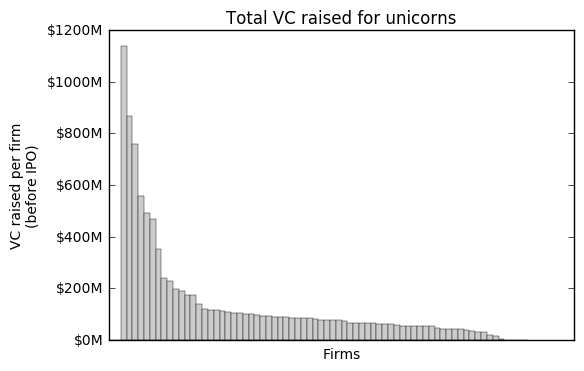

In [52]:
from matplotlib.ticker import FuncFormatter

x = most_funded['Firm']
y = sorted(most_funded['VC'], reverse=True)

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fM' % (x)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(6,4), dpi=200)
ax.yaxis.set_major_formatter(formatter)

#plt.figure(figsize=(6,4), dpi=200)

# Create a new subplot from a grid of 1x1
# plt.subplot(111)
plt.title("Total VC raised for unicorns")
plt.bar(range(len(x)+2), [0,0]+y, width = 1, facecolor='0.80', edgecolor='k', linewidth=0.3)

plt.ylabel('VC raised per firm\n(before IPO)')

# plt.set_xticks(x)                   # set 1 tick per year
plt.xlabel('Firms')
plt.xticks([])

plt.show()

In [53]:
cols = ['Firm', 'Sector', 'VC', 'Current Market Cap']
df = most_funded[cols]
df.set_index('Firm', inplace = True)
df.head(2)

,Sector,VC,Current Market Cap
Firm,,,
Apigee,B2B,173.0,535.07
Appfolio,B2B,30.0,729.54


In [54]:
tmp = df.groupby('Sector').sum().applymap(int)
tmp.index += ' Total'
tmp.sort_index(ascending=False, inplace = True)
tmp

,VC,Current Market Cap
B2C Total,6053,96775
B2B Total,3550,111356


In [55]:
tmp2 = df.groupby('Sector').mean().applymap(int)
tmp2.index += ' Average'
tmp2.sort_index(ascending=False, inplace = True)
tmp2

,VC,Current Market Cap
B2C Average,201,3225
B2B Average,88,2783


In [56]:
tmp.append(tmp2).applymap(lambda x: "${:,}".format(x))

,VC,Current Market Cap
B2C Total,"$6,053","$96,775"
B2B Total,"$3,550","$111,356"
B2C Average,$201,"$3,225"
B2B Average,$88,"$2,783"


In [57]:
tex(tmp.append(tmp2).applymap(lambda x: "${:,}".format(x)))

\begin{tabular}{lll}
\toprule
{} &      VC & Current Market Cap \\
\midrule
B2C Total   &  \$6,053 &            \$96,775 \\
B2B Total   &  \$3,550 &           \$111,356 \\
B2C Average &    \$201 &             \$3,225 \\
B2B Average &     \$88 &             \$2,783 \\
\bottomrule
\end{tabular}



In [58]:
most_funded['Mult'] = (most_funded['Current Market Cap'] / most_funded['VC']).replace([np.inf, -np.inf], np.nan)
most_funded.head()

,Firm,Founded,Ticker,IPO Share Price,Current Share Price,IPO Year,IPO Raise,Acquirer,Acquired Year,Acquired Price,Sector,Geo,Firm age,Years to IPO,VC,Current Market Cap,VC and IPO,$ Price change,% Price change,Mult
0,Apigee,2004,APIC,17.0,17.38,2015,87.0,-,-,-,B2B,SF,12,11,173.00,535.07,260.00,0.38,0.02,3.092890
1,Appfolio,2006,APPF,12.0,21.60,2015,71.4,-,-,-,B2B,LA,10,9,30.00,729.54,101.40,9.60,0.80,24.318000
2,Atlassian,2002,TEAM,21.0,28.76,2015,462.0,-,-,-,B2B,Sydney,14,13,0.00,6525.21,462.00,7.76,0.37,NaN
3,Barracuda Networks,2003,CUDA,18.0,24.08,2013,75.0,-,-,-,B2B,SF,13,10,45.61,1274.81,120.61,6.08,0.34,27.950230
4,Boingo,2001,WIFI,13.5,11.85,2011,77.9,-,-,-,B2C,LA,15,10,90.00,459.42,167.90,-1.65,-0.12,5.104667


In [59]:
tex(most_funded.iloc[:,list(range(8))+list(range(11,20))].head().T)

\begin{tabular}{llllll}
\toprule
{} &        0 &         1 &          2 &                   3 &        4 \\
\midrule
Firm                &   Apigee &  Appfolio &  Atlassian &  Barracuda Networks &   Boingo \\
Founded             &     2004 &      2006 &       2002 &                2003 &     2001 \\
Ticker              &     APIC &      APPF &       TEAM &                CUDA &     WIFI \\
IPO Share Price     &       17 &        12 &         21 &                  18 &     13.5 \\
Current Share Price &    17.38 &      21.6 &      28.76 &               24.08 &    11.85 \\
IPO Year            &     2015 &      2015 &       2015 &                2013 &     2011 \\
IPO Raise           &       87 &      71.4 &        462 &                  75 &     77.9 \\
Acquirer            &        - &         - &          - &                   - &        - \\
Geo                 &       SF &        LA &     Sydney &                  SF &       LA \\
Firm age            &       12 &        10 &         14

In [60]:
most_funded.head()
most_funded['Current Market Cap']

0       535.07
1       729.54
2      6525.21
3      1274.81
4       459.42
5      2004.51
6       567.24
7       253.36
8       375.33
9       720.77
10     2518.68
11     2800.00
12      125.00
13     1569.72
14     2500.00
16     2333.78
17     1818.55
18     1425.54
19     2225.94
20     3163.74
21     4220.59
22     3900.00
23     2031.51
24      545.14
25      312.43
26     1567.73
27     5686.93
28     2326.72
29     1956.36
30    26200.00
        ...   
41     1596.84
42       84.59
43     1500.00
44    13930.43
45     4106.90
46     1754.76
47      177.00
48     7749.73
49     4324.69
50     3572.13
51      663.00
52      103.96
53     1102.78
54     2500.00
55      533.43
56    13520.06
57     5771.18
58      509.20
59     2628.34
60     2259.53
61    16923.31
62      661.41
63      890.00
64     3150.60
65      121.09
66     2015.50
67     4389.56
68      500.00
69     2400.00
70     2453.63
Name: Current Market Cap, dtype: float64

In [61]:
least_20 = most_funded.dropna().sort_values('VC')[1:21]
least_20 = least_20[['VC', 'Current Market Cap','Mult']].mean()
least_20

VC                      44.90900
Current Market Cap    2183.97750
Mult                    63.03569
dtype: float64

In [62]:
most_20 = most_funded.dropna().sort_values('VC')[-20:]
most_20 = most_20[['VC', 'Current Market Cap','Mult']].mean()
most_20

VC                     332.686500
Current Market Cap    3182.942000
Mult                    12.956015
dtype: float64

In [63]:
pd.DataFrame([most_20, least_20], index=['most_20', 'least_20']).applymap(lambda x: round(x, 2))

,VC,Current Market Cap,Mult
most_20,332.69,3182.94,12.96
least_20,44.91,2183.98,63.04


In [64]:
tex(pd.DataFrame([most_20, least_20], index=['most_20', 'least_20']).applymap(lambda x: round(x, 2)))

\begin{tabular}{lrrr}
\toprule
{} &      VC &  Current Market Cap &   Mult \\
\midrule
most\_20  &  332.69 &             3182.94 &  12.96 \\
least\_20 &   44.91 &             2183.98 &  63.04 \\
\bottomrule
\end{tabular}



In [65]:
cols = ['Sector', 'VC', '% Price change', 'Firm age', 'Years to IPO', 'Current Market Cap', 'Mult']
df = most_funded[cols]
df.columns = ['Sector', 'VC', 'Growth', 'Age', 'yearsIPO', 'marketCAP', 'Mult']

df.head(2)

,Sector,VC,Growth,Age,yearsIPO,marketCAP,Mult
0,B2B,173.0,0.02,12,11,535.07,3.09289
1,B2B,30.0,0.80,10,9,729.54,24.31800


In [66]:
res = smf.ols(formula='Growth ~ VC + yearsIPO + C(Sector)', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1.980
Date:                Tue, 22 Nov 2016   Prob (F-statistic):              0.126
Time:                        04:14:56   Log-Likelihood:                -105.55
No. Observations:                  70   AIC:                             219.1
Df Residuals:                      66   BIC:                             228.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            1.3677      0.589  

In [67]:
res = smf.ols(formula='Growth ~ VC + Age + yearsIPO + C(Sector)', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Growth   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     2.577
Date:                Tue, 22 Nov 2016   Prob (F-statistic):             0.0456
Time:                        04:14:56   Log-Likelihood:                -103.41
No. Observations:                  70   AIC:                             216.8
Df Residuals:                      65   BIC:                             228.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            0.4750      0.725  

In [68]:
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &      Growth      & \textbf{  R-squared:         } &     0.137   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &     0.084   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     2.577   \\
\textbf{Date:}             & Tue, 22 Nov 2016 & \textbf{  Prob (F-statistic):} &   0.0456    \\
\textbf{Time:}             &     04:14:56     & \textbf{  Log-Likelihood:    } &   -103.41   \\
\textbf{No. Observations:} &          70      & \textbf{  AIC:               } &     216.8   \\
\textbf{Df Residuals:}     &          65      & \textbf{  BIC:               } &     228.1   \\
\textbf{Df Model:}         &           4      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
                          & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$>$$|$t$|$} & \textbf{[95.0\% Conf. Int.]}  \\
\mid

In [69]:
res = smf.ols(formula='Mult ~ VC + yearsIPO + C(Sector)', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   Mult   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.494
Date:                Tue, 22 Nov 2016   Prob (F-statistic):              0.225
Time:                        04:14:56   Log-Likelihood:                -434.79
No. Observations:                  66   AIC:                             877.6
Df Residuals:                      62   BIC:                             886.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          230.1760     96.074  